In [1]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [5]:
# Define transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing the images to the required size
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pre-trained model normalization
])

# Load the datasets (assuming you have your data directories)
train_dataset = datasets.ImageFolder(root='Skin_cancer_detection/melanoma_cancer_dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='Skin_cancer_detection/melanoma_cancer_dataset/test', transform=transform)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [6]:
# Load a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes in your dataset (e.g., 2 classes for binary classification)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Example for binary classification

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s] 


In [7]:
# Loss function (cross-entropy for classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam or SGD)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
num_epochs = 10  # Set the number of epochs

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    # Print the loss and accuracy at the end of each epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch 1/10, Loss: 0.2896, Accuracy: 88.57%
Epoch 2/10, Loss: 0.2364, Accuracy: 90.48%
Epoch 3/10, Loss: 0.2145, Accuracy: 91.97%
Epoch 4/10, Loss: 0.1952, Accuracy: 92.47%
Epoch 5/10, Loss: 0.1896, Accuracy: 92.48%
Epoch 6/10, Loss: 0.1699, Accuracy: 93.20%
Epoch 7/10, Loss: 0.1677, Accuracy: 93.60%
Epoch 8/10, Loss: 0.1666, Accuracy: 93.53%
Epoch 9/10, Loss: 0.1631, Accuracy: 93.60%
Epoch 10/10, Loss: 0.1498, Accuracy: 94.22%


In [9]:
# Switch model to evaluation mode
model.eval()
val_correct = 0
val_total = 0
val_preds = []
val_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)

val_accuracy = 100 * val_correct / val_total
print(f"Validation Accuracy: {val_accuracy:.2f}%")

# Optionally, calculate other metrics like confusion matrix, F1-score, etc.


Validation Accuracy: 92.10%


In [10]:
torch.save(model.state_dict(), "skin_cancer_model.pth")


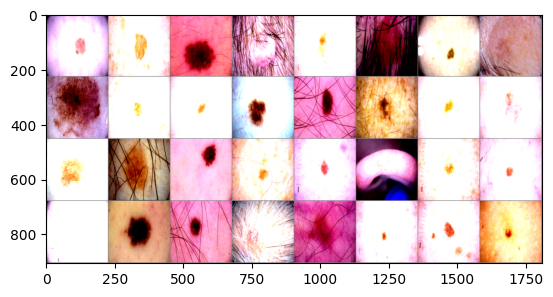

Predicted:  0 0 0 0 0 0 1 0


In [16]:
import torchvision
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Visualize some test images and their predictions
model.eval()
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Make predictions
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{predicted[j]}' for j in range(8)))
